### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

### Reading the dataset

In [2]:
data = pd.read_csv('./Database/userstwitter.csv', delimiter=';')

data.head()

,item_id,user_who_published,user_id,text,is_retweet,is_liked,is_quoted,retweet_count,like_count,quote_count,reply_count,user_tweets_count,user_likes_count,user_followees_count,user_followers_count,user_listed_count,tweet_date,user_is_verified,user_registration_date
0,18973154081,100220864,100220864,My Official First single out NOW on I Tunes! J...,0,0,0,1326,5168,374,156,4769,507,93,43302107,33942,2010-07-20 06:21:57,1,2009-12-29 13:07:04
1,133863536169451520,114894699,114894699,"system is currently having issues, we are work...",0,0,0,3563,425,12,313,60,0,1,2107812,3166,2011-11-08 11:08:48,1,2010-02-16 23:35:05
2,133992333908770816,114894699,114894699,service has been fully restored. sorry for th...,0,0,0,669,260,7,208,60,0,1,2107812,3166,2011-11-08 19:40:36,1,2010-02-16 23:35:05
3,142304671904694272,114894699,114894699,sorry there was a brief outage today approxima...,0,0,0,350,137,0,89,60,0,1,2107812,3166,2011-12-01 18:10:52,1,2010-02-16 23:35:05
4,143726488821305345,114894699,114894699,"sorry, system is having problems. we are work...",0,0,0,2067,143,1,83,60,0,1,2107812,3166,2011-12-05 16:20:39,1,2010-02-16 23:35:05


### #1 Feature Engineering

In [3]:
columns_to_normalize = ['retweet_count', 'like_count', 'quote_count', 'reply_count', 'user_tweets_count', 'user_likes_count', 'user_followees_count', 'user_followers_count', 'user_listed_count']  # List of column names to convert

for column in columns_to_normalize:
    data[column] = pd.to_numeric(data[column], errors='coerce')
    
data['user_who_published'] = data['user_who_published'].astype('int64')
data['tweet_date'] = pd.to_datetime(data['tweet_date'])
data['user_registration_date'] = pd.to_datetime(data['user_registration_date'])

now = pd.Timestamp(datetime.now())
data['tweet_date'] = (now - data['tweet_date']).dt.days
data['user_registration_date'] = (now - data['user_registration_date']).dt.days

data['tweet_date'] = 1 - ((data['tweet_date'] - data['tweet_date'].min()) / (data['tweet_date'].max() - data['tweet_date'].min()))
data['user_registration_date'] = 1 - ((data['user_registration_date'] - data['user_registration_date'].min()) / (data['user_registration_date'].max() - data['user_registration_date'].min()))

data[columns_to_normalize] = data[columns_to_normalize].fillna(0)
    
data.head()

,item_id,user_who_published,user_id,text,is_retweet,is_liked,is_quoted,retweet_count,like_count,quote_count,reply_count,user_tweets_count,user_likes_count,user_followees_count,user_followers_count,user_listed_count,tweet_date,user_is_verified,user_registration_date
0,18973154081,100220864,100220864,My Official First single out NOW on I Tunes! J...,0,0,0,1326,5168,374,156,4769,507,93,43302107,33942,0.000000,1,0.252379
1,133863536169451520,114894699,114894699,"system is currently having issues, we are work...",0,0,0,3563,425,12,313,60,0,1,2107812,3166,0.122459,1,0.261347
2,133992333908770816,114894699,114894699,service has been fully restored. sorry for th...,0,0,0,669,260,7,208,60,0,1,2107812,3166,0.122459,1,0.261347
3,142304671904694272,114894699,114894699,sorry there was a brief outage today approxima...,0,0,0,350,137,0,89,60,0,1,2107812,3166,0.128377,1,0.261347
4,143726488821305345,114894699,114894699,"sorry, system is having problems. we are work...",0,0,0,2067,143,1,83,60,0,1,2107812,3166,0.129406,1,0.261347


#### 1.1 Visualizing engagement metrics distribuition

c:\Users\Paulo Roberto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


retweet_count - Shapiro-Wilk Test statistics=0.195, p=0.000
like_count - Shapiro-Wilk Test statistics=0.093, p=0.000
quote_count - Shapiro-Wilk Test statistics=0.145, p=0.000
reply_count - Shapiro-Wilk Test statistics=0.048, p=0.000
user_tweets_count - Shapiro-Wilk Test statistics=0.083, p=0.000
user_likes_count - Shapiro-Wilk Test statistics=0.486, p=0.000
user_followees_count - Shapiro-Wilk Test statistics=0.383, p=0.000
user_followers_count - Shapiro-Wilk Test statistics=0.130, p=0.000
user_listed_count - Shapiro-Wilk Test statistics=0.471, p=0.000


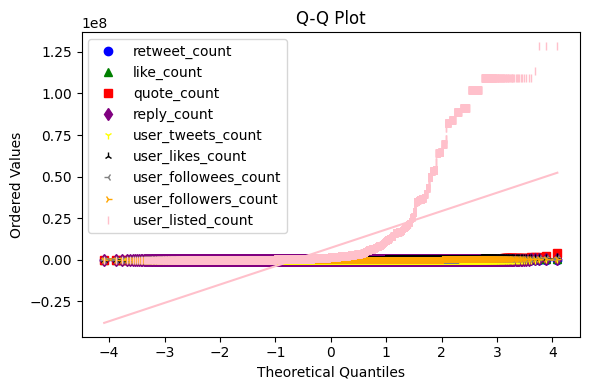

In [4]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Prepare the figure with specified dimensions
plt.figure(figsize=(6, 4))

# Combined settings for each column: index, color, label, linestyle, marker
column_settings = [
    (6, 'blue', 'retweet_count', '-', 'o'),
    (7, 'green', 'like_count', '--', '^'),
    (8, 'red', 'quote_count', '-.', 's'),
    (9, 'purple', 'reply_count', ':', 'd'),
    (10, 'yellow', 'user_tweets_count', '-', '1'),
    (11, 'black', 'user_likes_count', '--', '2'),
    (12, 'gray', 'user_followees_count', '-.', '3'),
    (13, 'orange', 'user_followers_count', ':', '4'),
    (14, 'pink', 'user_listed_count', '-', '|')
]

# Plot Q-Q plots and perform Shapiro-Wilk tests
for col, color, label, linestyle, marker in column_settings:
    (osm, osr), (slope, intercept, _) = stats.probplot(data.iloc[:, col], dist="norm", plot=None)
    plt.plot(osm, osr, marker=marker, linestyle='', color=color, label=label)  # Plot data points
    plt.plot(osm, slope*osm + intercept, linestyle=linestyle, color=color)  # Plot regression line
    
    # Shapiro-Wilk Test for each column
    stat, p = stats.shapiro(data.iloc[:, col])
    print(f'{label} - Shapiro-Wilk Test statistics={stat:.3f}, p={p:.3f}')

plt.title('Q-Q Plot')
plt.legend(loc='best')  # Improved legend placement
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

#### 1.2 Normalizing engagement metrics using Z-Score
$$
Z = \frac{X - \mu}{\sigma}
$$

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
data[columns_to_normalize].head()

,retweet_count,like_count,quote_count,reply_count,user_tweets_count,user_likes_count,user_followees_count,user_followers_count,user_listed_count
0,0.002428,0.001225,0.001721,0.000949,0.002928,0.000618,0.000143,0.337090,0.062102
1,0.006525,0.000101,0.000055,0.001903,0.000036,0.000000,0.000002,0.016409,0.005793
2,0.001225,0.000062,0.000032,0.001265,0.000036,0.000000,0.000002,0.016409,0.005793
3,0.000641,0.000032,0.000000,0.000541,0.000036,0.000000,0.000002,0.016409,0.005793
4,0.003786,0.000034,0.000005,0.000505,0.000036,0.000000,0.000002,0.016409,0.005793


#### 1.2 Visualizing engagement metrics distribuition after normalization

c:\Users\Paulo Roberto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


retweet_count - Shapiro-Wilk Test statistics=0.195, p=0.000
like_count - Shapiro-Wilk Test statistics=0.093, p=0.000
quote_count - Shapiro-Wilk Test statistics=0.145, p=0.000
reply_count - Shapiro-Wilk Test statistics=0.048, p=0.000
user_tweets_count - Shapiro-Wilk Test statistics=0.083, p=0.000
user_likes_count - Shapiro-Wilk Test statistics=0.486, p=0.000
user_followees_count - Shapiro-Wilk Test statistics=0.383, p=0.000
user_followers_count - Shapiro-Wilk Test statistics=0.130, p=0.000
user_listed_count - Shapiro-Wilk Test statistics=0.471, p=0.000
 - Shapiro-Wilk Test statistics=0.557, p=0.000


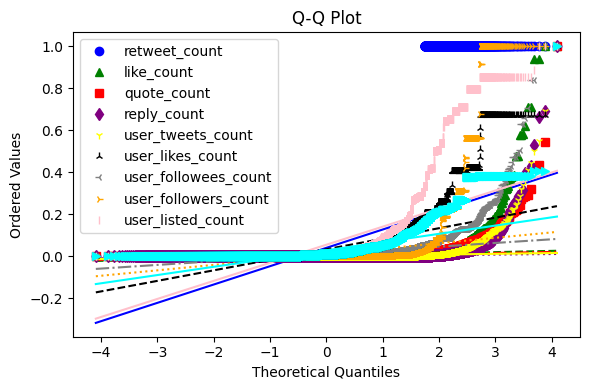

In [6]:
# Prepare the figure
plt.figure(figsize=(6, 4))

# Column indices and their respective settings
column_settings = [
    (6, 'blue', 'retweet_count', '-', 'o'),
    (7, 'green', 'like_count', '--', '^'),
    (8, 'red', 'quote_count', '-.', 's'),
    (9, 'purple', 'reply_count', ':', 'd'),
    (10, 'yellow', 'user_tweets_count', '-', '1'),
    (11, 'black', 'user_likes_count', '--', '2'),
    (12, 'gray', 'user_followees_count', '-.', '3'),
    (13, 'orange', 'user_followers_count', ':', '4'),
    (14, 'pink', 'user_listed_count', '-', '|'),
    (15, 'cyan', '', '-', '>')  # Note: Missing label here, adjust as necessary
]

# Plot Q-Q plots and perform Shapiro-Wilk tests
for col, color, label, linestyle, marker in column_settings:
    (osm, osr), (slope, intercept, _) = stats.probplot(data.iloc[:, col], dist="norm", plot=None)
    plt.plot(osm, osr, marker=marker, linestyle='', color=color, label=label)  # Plot data points
    plt.plot(osm, slope*osm + intercept, linestyle=linestyle, color=color)  # Plot regression line
    
    # Shapiro-Wilk Test for each column
    stat, p = stats.shapiro(data.iloc[:, col])
    print(f'{label} - Shapiro-Wilk Test statistics={stat:.3f}, p={p:.3f}')

plt.title('Q-Q Plot')
plt.legend(loc='best')  # Improved legend placement
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

### 2 Engagement Metrics

In [7]:
# Correcting the initial aggregation
grouped_data = data.groupby('user_who_published').agg(
    total_likes=('like_count', 'sum'),
    total_retweets=('retweet_count', 'sum'),
    total_replies=('reply_count', 'sum'),
    total_tweets=('item_id', 'count'),  # Assuming each row is a tweet; adjust the column name accordingly
    followers_count=('user_followers_count', 'max'),  # Assuming followers_count doesn't change per user in the dataset
    recency=('tweet_date', 'sum')  # Assuming followers_count doesn't change per user in the dataset
).reset_index()

grouped_data['engagement_rate'] = (grouped_data['total_likes'] + grouped_data['total_retweets'] + grouped_data['total_replies'] + grouped_data['recency']) / grouped_data['total_tweets'] * grouped_data['followers_count']

engagement_df = grouped_data[['user_who_published', 'engagement_rate']]

data_with_engagement = pd.merge(data, engagement_df, on='user_who_published', how='left')

data_with_engagement.head()

,item_id,user_who_published,user_id,text,is_retweet,is_liked,is_quoted,retweet_count,like_count,quote_count,reply_count,user_tweets_count,user_likes_count,user_followees_count,user_followers_count,user_listed_count,tweet_date,user_is_verified,user_registration_date,engagement_rate
0,18973154081,100220864,100220864,My Official First single out NOW on I Tunes! J...,0,0,0,0.002428,0.001225,0.001721,0.000949,0.002928,0.000618,0.000143,0.337090,0.062102,0.000000,1,0.252379,0.332486
1,133863536169451520,114894699,114894699,"system is currently having issues, we are work...",0,0,0,0.006525,0.000101,0.000055,0.001903,0.000036,0.000000,0.000002,0.016409,0.005793,0.122459,1,0.261347,0.003418
2,133992333908770816,114894699,114894699,service has been fully restored. sorry for th...,0,0,0,0.001225,0.000062,0.000032,0.001265,0.000036,0.000000,0.000002,0.016409,0.005793,0.122459,1,0.261347,0.003418
3,142304671904694272,114894699,114894699,sorry there was a brief outage today approxima...,0,0,0,0.000641,0.000032,0.000000,0.000541,0.000036,0.000000,0.000002,0.016409,0.005793,0.128377,1,0.261347,0.003418
4,143726488821305345,114894699,114894699,"sorry, system is having problems. we are work...",0,0,0,0.003786,0.000034,0.000005,0.000505,0.000036,0.000000,0.000002,0.016409,0.005793,0.129406,1,0.261347,0.003418


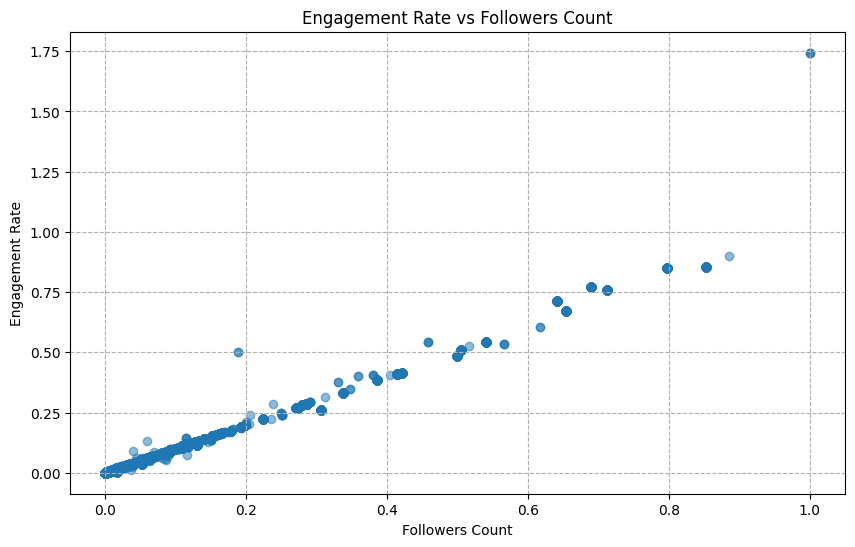

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(data_with_engagement['user_followers_count'], data_with_engagement['engagement_rate'], alpha=0.5)
plt.title('Engagement Rate vs Followers Count')
plt.xlabel('Followers Count')
plt.ylabel('Engagement Rate')
plt.grid(True, which="both", ls="--")  # Add grid for better readability, especially with log scale
plt.show()

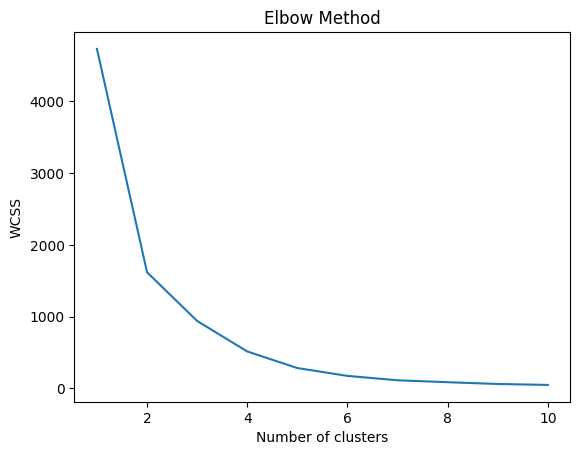

   cluster  average_engagement  count
0        0            0.003873   4636
1        1            0.719006     16
2        2            0.190143     77


C:\Users\Paulo Roberto\AppData\Local\Temp\ipykernel_30380\564792366.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engagement_df['cluster'] = y_kmeans


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming engagement_df is prepared with 'user_who_published' as IDs and 'engagement_rate' as values
X = engagement_df[['engagement_rate']].values  # Extracting the engagement rates for clustering

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Replace 'n_clusters' with the chosen number based on the elbow method
n_clusters = 3  # Example value
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original DataFrame
engagement_df['cluster'] = y_kmeans


# Group by cluster and calculate average engagement rate, or any other statistics of interest
cluster_analysis = engagement_df.groupby('cluster').agg(
    average_engagement=('engagement_rate', 'mean'),
    count=('user_who_published', 'count')
).reset_index()

print(cluster_analysis)

# Ensure this line comes after your clustering code but before your plotting code
# This merges the followers count into engagement_df based on user_who_published
engagement_df = pd.merge(engagement_df, grouped_data[['user_who_published', 'followers_count']], on='user_who_published', how='left')



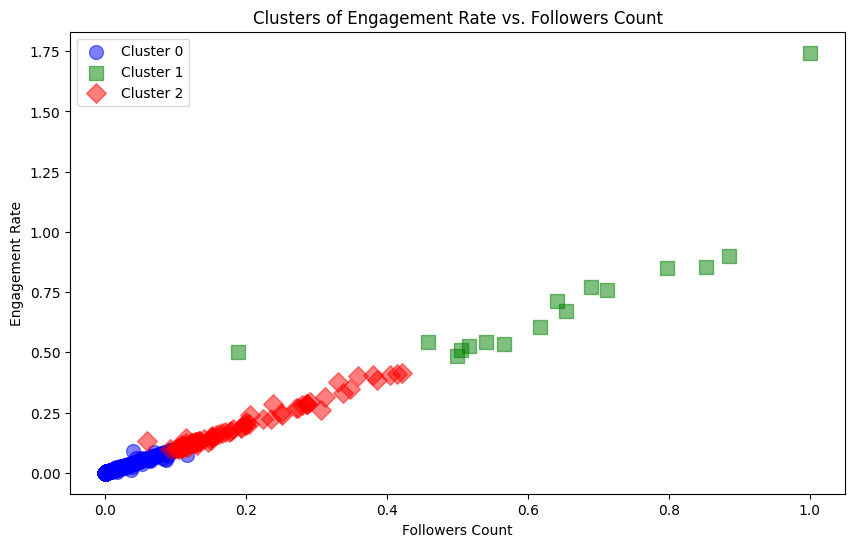

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define markers and colors
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

# Plot each cluster with its own marker and color
for i in range(n_clusters):  # n_clusters is defined from your KMeans clustering
    clustered_data = engagement_df[engagement_df['cluster'] == i]
    plt.scatter(clustered_data['followers_count'], clustered_data['engagement_rate'],  # Adjust column name as needed
                s=100, c=colors[i], label=f'Cluster {i}', marker=markers[i], alpha=0.5)

plt.title('Clusters of Engagement Rate vs. Followers Count')
plt.xlabel('Followers Count')
plt.ylabel('Engagement Rate')
plt.legend()
plt.show()
